In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import copy
from models.fourier_nn import FourierNet
from floorplans.lidar.lidar import ClippedLidar2D, Lidar2D, RandomPoseLidarDataset, TrajectoryLidarDataset, OnlineTrajectoryLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

In [4]:
data_dir = "../floorplans/32_data"

waypoint_dir = os.path.join(data_dir, "tight_paths")
# waypoint_dir = os.path.join(data_dir, "minimal_overlap")

img_path = os.path.join(data_dir, "floor_img.png")

# Data parameters
num_beams = 20
beam_samps = 25
beam_length = 0.2
spline_res = 30
samp_distribution_factor = 1.0
collision_samps = 50
fine_samps = 3
num_scans_in_window = 500
lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps, 
    samp_distribution_factor, collision_samps, fine_samps,
    border_width=30)
#lidar = ClippedLidar2D(img_path, num_beams, beam_length, beam_samps,
#    border_width=30)

datasets = []
for name in glob.glob1(waypoint_dir, "*.npy"):
    waypoints = np.load(os.path.join(waypoint_dir, name))
    ds = OnlineTrajectoryLidarDataset(lidar, waypoints, 
        spline_res, num_scans_in_window)
    #ds = RandomPoseLidarDataset(lidar, 6000)
    print()
    print(name, " : ", len(ds), " scan points")
    print(name, " : ", (torch.sum(ds.scans[:,2] == 1.0) / ds.scans.shape[0]).data.item(), "hd point ratio")
    datasets.append(ds)

# Concatenate the entire dataset
#cent_ds = torch.utils.data.ConcatDataset(datasets)
num_validation_scans = 500
valset = RandomPoseLidarDataset(lidar, num_validation_scans)


1.npy  :  1215000  scan points
1.npy  :  0.03564197530864197 hd point ratio

2.npy  :  1215000  scan points
2.npy  :  0.029875720164609054 hd point ratio

4.npy  :  1185000  scan points
4.npy  :  0.0322 hd point ratio

7.npy  :  1215000  scan points
7.npy  :  0.028678189300411522 hd point ratio

3.npy  :  1215000  scan points
3.npy  :  0.03481810699588477 hd point ratio

5.npy  :  1215000  scan points
5.npy  :  0.03394814814814815 hd point ratio

6.npy  :  1215000  scan points
6.npy  :  0.030379423868312758 hd point ratio


In [5]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
else: 
    device = torch.device("cpu")

# Setup model and centralized optimizer
model = FourierNet([2, 256, 64, 64, 64, 1], scale=0.05).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
#batch_size = 10000


loss = torch.nn.BCELoss()
val_loader = torch.utils.data.DataLoader(valset, batch_size=10000)

N = 7
batch_size = 12500
dloaders = []
diters = []
for i in range(N):
    dl = torch.utils.data.DataLoader(datasets[i], batch_size=batch_size)
    dloaders.append(dl)
    diters.append(iter(dl))

epoch_tracker = torch.zeros(N)
current_epoch = 0
epochs = 4
from torch.optim.lr_scheduler import StepLR

# 创建StepLR实例
scheduler = StepLR(opt, step_size=66, gamma=0.5)
v_loss_list=[]
X, Y = np.meshgrid(torch.Tensor(lidar.xs), torch.Tensor(lidar.ys))
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
xlocs=torch.Tensor(xlocs)
ylocs=torch.Tensor(ylocs)
mesh_inputs = torch.hstack((xlocs, ylocs))
mesh_inputs = mesh_inputs.to(device)
while current_epoch <= 200:
    locs = []
    dens = []
    for i in range(N):
        try:
            batch = next(diters[i])
        except StopIteration:
            epoch_tracker[i] += 1
            diters[i] = iter(dloaders[i])
            batch = next(diters[i])
        locs.append(batch[0].to(device))
        dens.append(batch[1].to(device))
        
    x = torch.cat(locs, axis=0)
    y = torch.cat(dens, axis=0)
        
    opt.zero_grad()
    pd = model.forward(x).squeeze()
    l = loss(pd, y)
    l.backward()
    opt.step()
    if torch.sum(epoch_tracker > current_epoch) >= N:
        current_epoch += 1
        print("-------------------------------")
        print("Epochs: ", epoch_tracker)
        with torch.no_grad():
            vloss = 0.0
            for batch in val_loader:
                x, y = batch[0].to(device), batch[1].to(device)
                pd = model.forward(x).squeeze()
                vloss += loss(pd, y).data
        scheduler.step()
        v_loss_list.append(vloss.item())
        print("Valid loss: ", vloss.item())
    if current_epoch%20==0:
        with torch.no_grad():
            mesh_dense = model.forward(mesh_inputs)
        torch.save(mesh_dense, "mesh/mesh_dense"+str(current_epoch)+".pt")
# torch.save(mesh_dense, "mesh_dense.pt")

-------------------------------
Epochs:  tensor([1., 1., 1., 1., 1., 1., 1.])
Valid loss:  5.03585150818252
-------------------------------
Epochs:  tensor([2., 2., 2., 2., 2., 2., 2.])
Valid loss:  4.904688827703425
-------------------------------
Epochs:  tensor([3., 3., 3., 3., 3., 3., 3.])
Valid loss:  4.557630773693396
-------------------------------
Epochs:  tensor([4., 4., 4., 4., 4., 4., 4.])
Valid loss:  4.140294231141497
-------------------------------
Epochs:  tensor([5., 5., 5., 5., 5., 5., 5.])
Valid loss:  4.09478570669935
-------------------------------
Epochs:  tensor([6., 6., 6., 6., 6., 6., 6.])
Valid loss:  3.745570940478039
-------------------------------
Epochs:  tensor([7., 7., 7., 7., 7., 7., 7.])
Valid loss:  3.4214270702913265
-------------------------------
Epochs:  tensor([8., 8., 8., 8., 8., 8., 8.])
Valid loss:  3.2202290735964314
-------------------------------
Epochs:  tensor([9., 9., 9., 9., 9., 9., 9.])
Valid loss:  2.954590319823685
-------------------

In [20]:
torch.save(model.state_dict(), "minimal_overlap.pt")
torch.save(v_loss_list, "minimal_overlap_v_loss_list.pt")

In [14]:
t=np.arange(0,len(v_loss_list)+1)*20
plt.figure(figsize=(10, 6))  # 设置图形的大小
ax = plt.subplot() 
v_loss_list.insert(0,17.35)
ax.plot(t,v_loss_list)
ax.grid()

NameError: name 'v_loss_list' is not defined

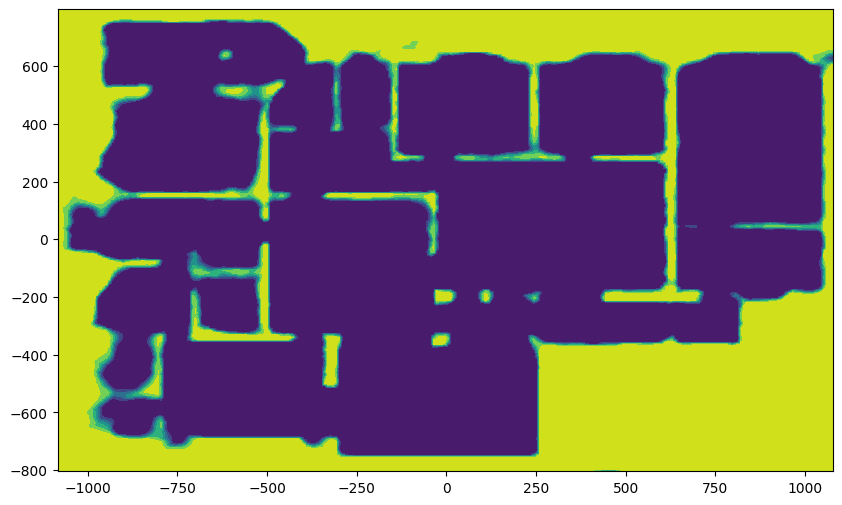

In [13]:
X, Y = np.meshgrid(torch.Tensor(lidar.xs), torch.Tensor(lidar.ys))
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
xlocs=torch.Tensor(xlocs)
ylocs=torch.Tensor(ylocs)
mesh_inputs = torch.hstack((xlocs, ylocs))
mesh_inputs = mesh_inputs.to(device)
plt.figure(figsize=(10, 6))  # 设置图形的大小
ax = plt.subplot() 
with torch.no_grad():
    mesh_dense = model.forward(mesh_inputs)
# torch.save(mesh_dense, "mesh_dense.pt")
# (fig, ax) = plt.subplots(figsize=(10, 10))
den=torch.load("../centralized/mesh/mesh_dense20.pt",map_location=torch.device('cpu'))

ax.tricontourf(xlocs.squeeze(), ylocs.squeeze(), den.squeeze().cpu())
# mesh_dense[:100]